In [1]:
import math, random

import gym
import numpy as np
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
from torch.autograd import Variable
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
os.listdir()
ckpt_dir = './checkpoints_base'
ckpt_names = []

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Use Cuda</h3>

In [3]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

<h2>Replay Buffer</h2>

In [4]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

<h2>Cart Pole Environment</h2>

In [5]:
env_id = "CartPole-v0"
env = gym.make(env_id)

<h2>Epsilon greedy exploration</h2>

In [6]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

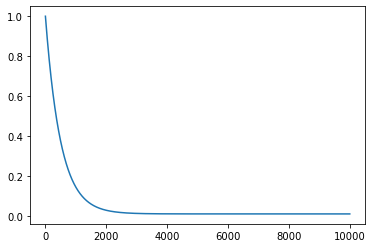

In [7]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

<h2>Double Deep Q Network</h2>

In [8]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data.item()
        else:
            action = random.randrange(env.action_space.n)
        return action

In [9]:
current_model = DQN(env.observation_space.shape[0], env.action_space.n)
target_model  = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters())

replay_buffer = ReplayBuffer(1000)

<h3>Synchronize current policy net and target net</h3>

In [16]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

In [11]:
update_target(current_model, target_model)

<h2>Computing Temporal Difference Loss</h2>

In [24]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    next_q_state_values = target_model(next_state) 

    q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1) 
    next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [8]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<h2>Training</h2>

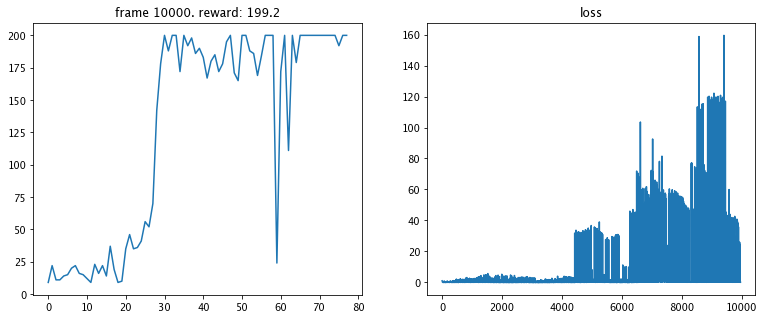

In [16]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

ckpt_dir = './checkpoints_base'
ckpt_names = []
dir_exist = os.path.exists(ckpt_dir)
if (dir_exist == 0):
    os.mkdir(ckpt_dir)


state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)
  
    if frame_idx % 100 == 0:
        update_target(current_model, target_model)
    
    # save checkpoints every 1000 frames
    if frame_idx % 1000 == 0:
        save_str = str(frame_idx) + '_DoubleDQN.ckpt'
        save_dir = os.path.join(ckpt_dir, save_str)
        ckpt_names.append(save_dir)
        torch.save(current_model.state_dict(), save_dir)


## Testing

In [17]:
for i in ckpt_names:
    print(i)

./checkpoints_base/1000_DoubleDQN.ckpt
./checkpoints_base/2000_DoubleDQN.ckpt
./checkpoints_base/3000_DoubleDQN.ckpt
./checkpoints_base/4000_DoubleDQN.ckpt
./checkpoints_base/5000_DoubleDQN.ckpt
./checkpoints_base/6000_DoubleDQN.ckpt
./checkpoints_base/7000_DoubleDQN.ckpt
./checkpoints_base/8000_DoubleDQN.ckpt
./checkpoints_base/9000_DoubleDQN.ckpt
./checkpoints_base/10000_DoubleDQN.ckpt


In [9]:
def plot_test(ckpt, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Test checkpoint %s. reward: %s' % (ckpt, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.show()

In [19]:
import gym
import random
env_id = "CartPole-v0"
env=gym.make(env_id).env
env.reset()
done=False
#env.render()
while not done:
    action = random.randrange(env.action_space.n)
    next_state,reward,done,_ = env.step(action)
    #env.render()
env.reset()
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))
# env.render()

Action Space Discrete(2)
State Space Box(4,)


In [20]:
env_id = "CartPole-v0"
# No exploring, only playin to the model for Testing
epsilon=0
# done=False

save_dir = './videos'
dir_exist = os.path.exists(save_dir)
if (dir_exist == 0):
    os.mkdir(save_dir)

def test(model):
    done=False
    model.eval()
    
    env_id = "CartPole-v0"
    env = gym.make(env_id).env
    # env = gym.wrappers.Monitor(env, save_dir, video_callable = lambda episode_idx: episode_idx%250==0)
    state = env.reset()
    #env.render()
    
    testReward=0
    while not done:
#         for frame_idx in range(1, num_frames + 1):=
#         epsilon = epsilon_by_frame(frame_idx)
        action = model.act(state, epsilon)

        next_state, reward, done, _ = env.step(action)
        #env.render()

        state = next_state
        testReward += reward
    state = env.reset()
    if done:
        env.close()

    return testReward


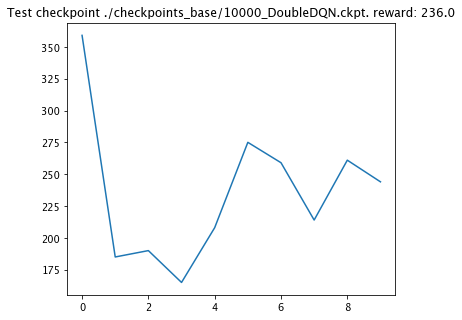

In [21]:
rewards = []
for ckpt in ckpt_names:
    load_ckpt = ckpt
    # Load the Model
    current_model = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
    current_model.load_state_dict(torch.load(load_ckpt))
    
    # run the loaded model, save the output
    r = test(current_model)

    rewards.append(r)
    plot_test(ckpt, rewards)

<p><hr></p>

<h1>Atari Environment</h1>

In [10]:
from wrappers import make_atari, wrap_deepmind, wrap_pytorch

In [11]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [12]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            state = state.to(device)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

In [17]:
current_model = CnnDQN(env.observation_space.shape, env.action_space.n)
current_model.load_state_dict(torch.load('checkpoints_base/690000_DoubleDQN.ckpt'))
target_model  = CnnDQN(env.observation_space.shape, env.action_space.n)
target_model.load_state_dict(torch.load('checkpoints_base/690000_DoubleDQN.ckpt'))

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), lr=0.0001)

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

update_target(current_model, target_model)

In [18]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

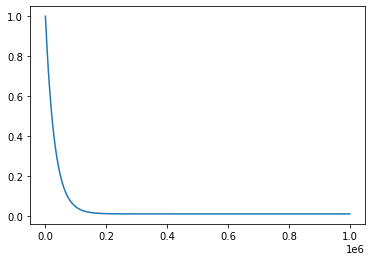

In [19]:
plt.plot([epsilon_by_frame(i) for i in range(1000000)])

## Training

In [27]:
num_frames = 1000000
batch_size = 32
gamma      = 0.99
losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 1000 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 1000 == 0:
        update_target(current_model, target_model)
        
    # save checkpoints every 10000 frames
    if frame_idx % 10000 == 0:
        save_str = str(frame_idx) + '_DoubleDQN.ckpt'
        save_dir = os.path.join(ckpt_dir, save_str)
        ckpt_names.append(save_dir)
        torch.save(current_model.state_dict(), save_dir)
        

NameError: name 'b' is not defined

# Vertical Filter Training

In [21]:
from scipy.ndimage import sobel

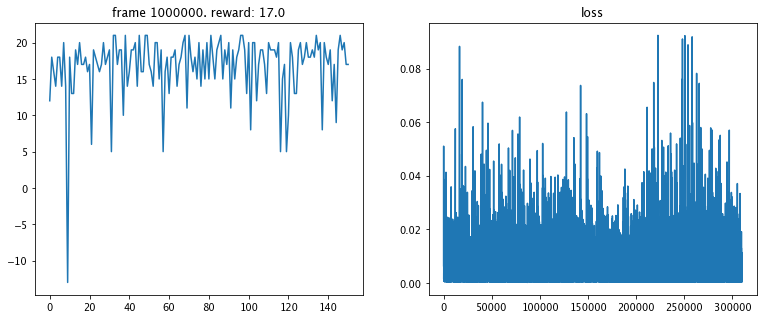

In [28]:
num_frames = 1000000
batch_size = 32
gamma      = 0.99
losses = []
all_rewards = []
episode_reward = 0


ckpt_dir = './checkpoints_vertical'
ckpt_names = []
dir_exist = os.path.exists(ckpt_dir)
if (dir_exist == 0):
    os.mkdir(ckpt_dir)

state = env.reset()
for frame_idx in range(690001, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)
    next_state, reward, done, _ = env.step(action)
    next_state = sobel(next_state, 1)  # vertical edges
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 1000 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 1000 == 0:
        update_target(current_model, target_model)
        
    # save checkpoints every 10000 frames
    if frame_idx % 10000 == 0:
        save_str = str(frame_idx) + '_DoubleDQN.ckpt'
        save_dir = os.path.join(ckpt_dir, save_str)
        ckpt_names.append(save_dir)
        torch.save(current_model.state_dict(), save_dir)

# Generic Laplace Testing

In [24]:
from scipy.ndimage import gaussian_laplace

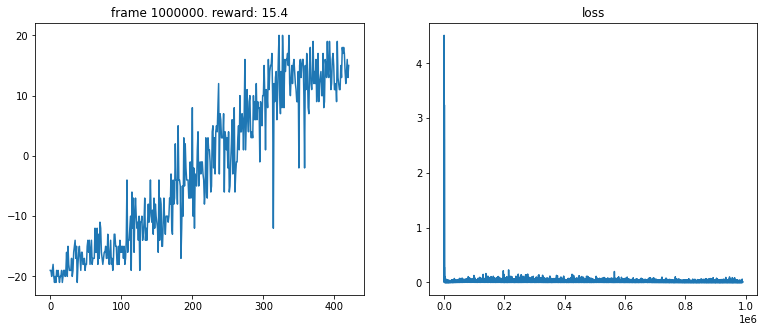

In [25]:
num_frames = 1000000
batch_size = 32
gamma      = 0.99
losses = []
all_rewards = []
episode_reward = 0


ckpt_dir = './checkpoints_laplace'
ckpt_names = []
dir_exist = os.path.exists(ckpt_dir)
if (dir_exist == 0):
    os.mkdir(ckpt_dir)

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)
    next_state, reward, done, _ = env.step(action)
    next_state = gaussian_laplace(next_state, sigma=3)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 1000 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 1000 == 0:
        update_target(current_model, target_model)
        
    # save checkpoints every 10000 frames
    if frame_idx % 10000 == 0:
        save_str = str(frame_idx) + '_DoubleDQN.ckpt'
        save_dir = os.path.join(ckpt_dir, save_str)
        ckpt_names.append(save_dir)
        torch.save(current_model.state_dict(), save_dir)

## Testing with Visualization

In [0]:
from wrappers import make_atari, wrap_deepmind, wrap_pytorch
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [0]:
env.observation_space.shape

In [0]:
# Loading Checkpoints

# current_model = CnnDQN(env.observation_space.shape, env.action_space.n)
# target_model  = CnnDQN(env.observation_space.shape, env.action_space.n)

current_model_Atari = CnnDQN(env.observation_space.shape, env.action_space.n).to(device)
current_model_Atari.load_state_dict(torch.load('current.ckpt'))

target_model_Atari = CnnDQN(env.observation_space.shape, env.action_space.n).to(device)
target_model_Atari.load_state_dict(torch.load('target.ckpt'))

In [0]:
# env_id = "CartPole-v0"
# No exploring, only playin to the model for Testing
epsilon=0
# done=False

def test(model):
    done=False
    model.eval()
    
    env = make_atari(env_id)
    env = wrap_deepmind(env)
    env = wrap_pytorch(env)
    
    state = env.reset()
    #env.render()
    
    testReward=0
    
    while not done:
#         for frame_idx in range(1, num_frames + 1):=
#         epsilon = epsilon_by_frame(frame_idx)
        action = model.act(state, epsilon)

        next_state, reward, done, _ = env.step(action)
        #env.render()

        state = next_state
        testReward += reward
    state = env.reset()
    if done:
        env.close()

    return testReward


In [0]:
rewards = []
for ckpt in ckpt_names:
    load_ckpt = ckpt
    # Load the Model
    current_model = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
    current_model.load_state_dict(torch.load(load_ckpt))
    
    # run the loaded model, save the output
    r = test(current_model)

    rewards.append(r)
    plot_test(ckpt, rewards)